In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import re
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt


### Clear day-ahead load

In [2]:
# Specify the directory you want to use
directory = './DAM/Load'

dataframes = []  # list to store dataframes
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

In [3]:
values = ['CA ISO-TAC', 'MWD-TAC', 'PGE-TAC','SCE-TAC','SDGE-TAC','VEA-TAC']
df_selected = combined_df[combined_df['TAC_AREA_NAME'].isin(values)]
df_sorted = df_selected.sort_values(by=['OPR_DT', 'OPR_HR',]).reset_index(drop=True)

In [4]:
CAISO = df_sorted[df_sorted['TAC_AREA_NAME']=='CA ISO-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[16:8776].reset_index(drop=True)
Zone1 = df_sorted[df_sorted['TAC_AREA_NAME']=='PGE-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[16:8776].reset_index(drop=True)
Zone2_values = ['MWD-TAC','SCE-TAC','VEA-TAC']
Zone2_sep = df_sorted[df_sorted['TAC_AREA_NAME'].isin(Zone2_values)]
Zone2 = Zone2_sep.groupby(['INTERVALSTARTTIME_GMT'])['MW'].sum().iloc[16:8776].reset_index()
Zone3 = df_sorted[df_sorted['TAC_AREA_NAME']=='SDGE-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[16:8776].reset_index(drop=True)

In [5]:
train_pre = pd.concat([CAISO['INTERVALSTARTTIME_GMT'], CAISO['MW'], Zone1['MW'], Zone2['MW'], Zone3['MW']], axis=1)
train_pre.columns = ['INTERVALSTARTTIME_GMT', 'CAISO', 'Zone1', 'Zone2', 'Zone3']
train_pre['CAISO'] = train_pre[['Zone1', 'Zone2', 'Zone3']].sum(axis=1)
train_pre['INTERVALSTARTTIME_GMT'] = pd.to_datetime(train_pre['INTERVALSTARTTIME_GMT'])
train_pre.set_index('INTERVALSTARTTIME_GMT', inplace=True)

In [6]:
DAMLoad = train_pre.resample('5T').ffill()

In [34]:
train_pre['CAISO'].mean()

25118.036615296805

### K-Means training

In [7]:
reshaped_data = train_pre[['CAISO', 'Zone1', 'Zone2', 'Zone3']].values.reshape(-1, 24*4)/max(train_pre['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features

kmeans = KMeans(n_clusters= 8, random_state=0).fit(reshaped_data)

labels = kmeans.labels_  # the label of the cluster each data point belongs to

C:\Program Files\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


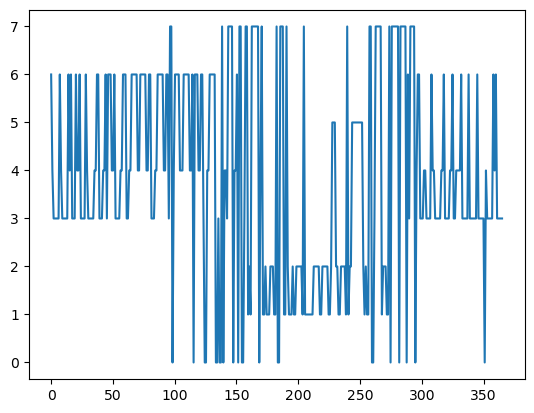

In [8]:
# Generate some data
x1 = np.linspace(0, 365, 365)
y1 = labels

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x1, y1)

# Show the plot
plt.show()

### Clear real-time load

In [9]:
# Specify the directory you want to use
directory = './RTD/Load'

dataframes = []  # list to store dataframes
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

In [10]:
combined_df = combined_df.sort_values(by=['INTERVALSTARTTIME_GMT', 'TAC_AREA_NAME']).reset_index(drop=True)

In [11]:
values = ['CA ISO-TAC', 'MWD-TAC', 'PGE-TAC','SCE-TAC','SDGE-TAC','VEA-TAC']
df_selected = combined_df[combined_df['TAC_AREA_NAME'].isin(values)]
df_selected = df_selected[df_selected['XML_DATA_ITEM']=='SYS_FCST_5MIN_MW'].reset_index(drop=True)[['INTERVALSTARTTIME_GMT', 'TAC_AREA_NAME', 'MW']]

In [12]:
df_selected['INTERVALSTARTTIME_GMT'] = pd.to_datetime(df_selected['INTERVALSTARTTIME_GMT'])
df_pivot = df_selected.pivot(index='INTERVALSTARTTIME_GMT', columns='TAC_AREA_NAME', values='MW')
df_resampled = df_pivot.resample('5T').asfreq()
df_interpolated = df_resampled.interpolate(method='linear')

In [13]:
df_interpolated

TAC_AREA_NAME,CA ISO-TAC,MWD-TAC,PGE-TAC,SCE-TAC,SDGE-TAC,VEA-TAC
INTERVALSTARTTIME_GMT,,,,,,
2021-12-31 08:00:00+00:00,22062.04,212.02,9385.72,9336.17,2002.17,70.63
2021-12-31 08:05:00+00:00,21971.23,211.99,9347.57,9292.39,1996.91,70.80
2021-12-31 08:10:00+00:00,21877.07,211.80,9305.30,9250.18,1992.05,70.25
2021-12-31 08:15:00+00:00,21781.70,211.40,9258.01,9210.23,1987.69,70.47
2021-12-31 08:20:00+00:00,21672.74,210.66,9202.12,9171.41,1977.69,69.99
...,...,...,...,...,...,...
2023-01-01 07:35:00+00:00,20993.08,206.81,8771.84,8897.09,2051.90,63.99
2023-01-01 07:40:00+00:00,20941.46,206.81,8756.46,8867.53,2049.83,63.81
2023-01-01 07:45:00+00:00,20734.96,206.82,8604.44,8807.64,2054.20,63.85


In [14]:
CAISO = df_interpolated['CA ISO-TAC'][192:105301]
Zone1 = df_interpolated['PGE-TAC'][192:105301]
Zone2 = (df_interpolated['MWD-TAC']+df_interpolated['SCE-TAC']+df_interpolated['VEA-TAC'])[192:105301]
Zone3 = df_interpolated['SDGE-TAC'][192:105301]
RTDLoad = pd.concat([CAISO, Zone1, Zone2, Zone3], axis=1)
RTDLoad.columns = ['CAISO', 'Zone1', 'Zone2', 'Zone3']
RTDLoad['CAISO'] = RTDLoad[['Zone1', 'Zone2', 'Zone3']].sum(axis=1)


### RTD load noise

In [15]:
RTDLoadNoise = (DAMLoad - RTDLoad)/max(DAMLoad['CAISO'])
RTDLoadNoise

,CAISO,Zone1,Zone2,Zone3
INTERVALSTARTTIME_GMT,,,,
2022-01-01 00:00:00+00:00,0.074608,0.034704,0.037299,0.002605
2022-01-01 00:05:00+00:00,0.070896,0.033263,0.035373,0.002260
2022-01-01 00:10:00+00:00,0.067358,0.031445,0.034135,0.001778
2022-01-01 00:15:00+00:00,0.063494,0.029517,0.032782,0.001195
2022-01-01 00:20:00+00:00,0.058630,0.026618,0.030591,0.001421
...,...,...,...,...
2022-12-31 22:40:00+00:00,0.026531,0.010214,0.017954,-0.001637
2022-12-31 22:45:00+00:00,0.027657,0.011692,0.017666,-0.001701
2022-12-31 22:50:00+00:00,0.026550,0.011194,0.017335,-0.001979


In [47]:
RTDLoadNoise['CAISO'].mean()

0.03347228399630123

In [16]:
### find closest date to each cluster centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reshaped_data)
noise_list = []
for i in closest:
    selected_rows = RTDLoadNoise.loc[RTDLoadNoise.index.date == train_pre.index.date[24*i]].values
    noise_list.append(selected_rows)
noise_list = np.stack(noise_list)
# j = 0
# for i in closest:
#     selected_rows = RTDLoadNoise.loc[RTDLoadNoise.index.date == train_pre.index.date[24*i]]
#     selected_rows.to_csv(f"./noise/cluster_{j}.csv")
#     j=j+1

In [43]:
noise_list[0]

array([[ 0.08698932,  0.04903442,  0.03404043,  0.00391448],
       [ 0.08675762,  0.04925169,  0.03387537,  0.00363056],
       [ 0.08312707,  0.04703567,  0.03298425,  0.00310714],
       ...,
       [ 0.01588083,  0.01061164,  0.0068667 , -0.00159751],
       [ 0.01313867,  0.00904531,  0.00610438, -0.00201102],
       [ 0.0106473 ,  0.00752866,  0.00551784, -0.00239919]])

In [44]:
noise_list[:, :, 0].mean()

0.032805576645102974

### ADS day-ahead load prediction

In [18]:
ADSLoad = pd.read_csv("./Processed Data/Load.csv")[['1','2','3']]
ADSLoad['CAISO'] = ADSLoad[['1', '2', '3']].sum(axis=1)
ADSLoad = ADSLoad[['CAISO', '1', '2', '3']]
reshaped_ADSLoad = ADSLoad.values.reshape(-1, 24*4)/max(ADSLoad['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features

In [19]:
ADSLoad

,CAISO,1,2,3
0,29370.457,12949.417,14087.040,2334
1,27192.138,11973.268,13042.870,2176
2,25677.304,11250.215,12423.089,2004
3,24654.114,10812.445,11977.669,1864
4,24345.909,10722.440,11805.469,1818
...,...,...,...,...
8779,42368.407,18691.857,19822.550,3854
8780,41712.485,18328.295,19595.190,3789
8781,40732.648,17809.728,19296.920,3626
8782,38889.429,16917.359,18549.070,3423


In [20]:
reshaped_ADSLoad

array([[0.45843352, 0.20212307, 0.21987984, ..., 0.21992401, 0.24020825,
        0.04187804],
       [0.45144062, 0.19712058, 0.21890398, ..., 0.21835495, 0.23788006,
        0.04301747],
       [0.45011146, 0.19781447, 0.21491425, ..., 0.22350383, 0.21634401,
        0.04069178],
       ...,
       [0.43936696, 0.19263336, 0.20857043, ..., 0.23267482, 0.2554846 ,
        0.04567094],
       [0.48129203, 0.20811127, 0.23389376, ..., 0.23980968, 0.26519459,
        0.04573338],
       [0.4931575 , 0.21379227, 0.24023431, ..., 0.24264184, 0.27193504,
        0.04835563]])

In [21]:
predictions = kmeans.predict(reshaped_ADSLoad)
predictions

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7,
       7, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 3,
       6, 6, 3, 7, 7, 7, 7, 3, 3, 3, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 3, 3, 6,
       3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 7, 7, 7, 3, 3, 6, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3, 7, 7, 2, 2, 7, 7,
       7, 2, 7, 7, 2, 2, 2, 2, 2, 7, 3, 7, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2,
       2, 2, 7, 7, 7, 3, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 5, 5, 2, 2, 2, 2, 2, 5, 5, 5, 2, 2, 2, 5, 5, 5, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 2, 2, 2, 2, 7,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 2, 2, 2, 2, 2, 2, 7, 2,
       2, 2, 2, 2, 3, 3, 2, 2, 7, 7, 7, 3, 3, 7, 7, 7, 7, 7, 3, 3, 3, 3,
       3, 7, 7, 3, 3, 3, 7, 7, 7, 7, 3, 3, 3, 3, 3,

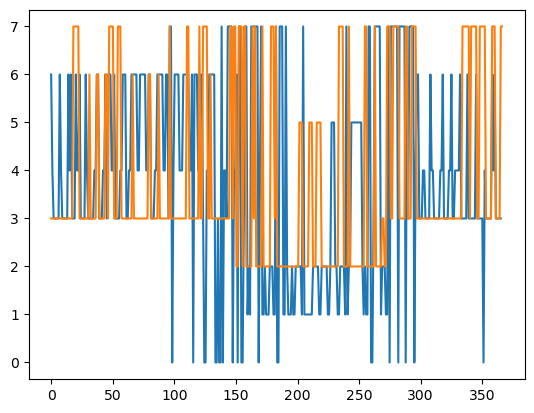

In [22]:
# Generate some data
x2 = np.linspace(0, 366, 366)
y2 = predictions

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x1, y1)

# Plot the data
ax.plot(x2, y2)

# Show the plot
plt.show()

### Apply noise to ADS load base on prediciton

In [32]:
ADSLoad['CAISO'].mean()

36103.0301625683

In [24]:
noise_list_ADS = max(ADSLoad['CAISO'])*noise_list
noise_list_ADS[7]

array([[ 2.53195686e+03,  2.42451524e+03,  1.09077093e+02,
        -1.63546975e+00],
       [ 2.21338982e+03,  2.27451395e+03, -2.73410591e+00,
        -5.83900153e+01],
       [ 2.09547370e+03,  2.17060544e+03, -5.15609928e+00,
        -6.99756331e+01],
       ...,
       [ 8.08433920e+02,  1.45429466e+03, -2.00638430e+02,
        -4.45222306e+02],
       [ 7.59694424e+02,  1.39987471e+03, -1.87155168e+02,
        -4.53025120e+02],
       [ 7.38146174e+02,  1.32441838e+03, -1.34770198e+02,
        -4.51502011e+02]])

In [35]:
noise_list.max()

0.08743887529371251

In [ ]:
noise_list_ADS[predictions[0]]+ADSLoad_repeated[0:288].values

In [ ]:
ADSLoad_repeated = ADSLoad.loc[ADSLoad.index.repeat(12)].reset_index(drop=True)

In [ ]:
ADSRTDLoad = np.empty((0, 4))
for i in range(len(reshaped_ADSLoad)):
    adjust = noise_list_ADS[predictions[i]]+ADSLoad_repeated[i*288:i*288+288].values
    ADSRTDLoad = np.vstack((ADSRTDLoad, adjust))

In [ ]:
len(ADSRTDLoad)

In [ ]:
ADSLoad_rest = pd.read_csv("./Processed Data/Load.csv")[['4','5','6','7']]
new_index = np.arange(ADSLoad_rest.index.min(), ADSLoad_rest.index.max() + 1, 1/12)
ADSLoad_rest_reindexed = ADSLoad_rest.reindex(new_index)
ADSLoad_rest_interpolated = ADSLoad_rest_reindexed.interpolate(method='linear')
ADSLoad_rest_interpolated.values

In [ ]:
ADSLoad_RTD = np.hstack((ADSRTDLoad, df_interpolated))
np.savetxt("realtimeload.csv", ADSLoad_RTD, delimiter=",")
